In [89]:
import pickle as pk
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Visualization of LI Spectrum Dataset

This notebook aims to analyse and explore the resulting datasets. 


It is seprated into 2 parts : analysis of SSBCAPs  and Tau-PET .

## Useful Functions

In [124]:
def plot_with_custom_colors_LI(df, y, x, hue, col, col_wrap, hue_order, color_dict, save_file, ylim=[-0.5, 0.5]):
    """
    Function to plot the LI-spectrum. 
    Input : 
    ------
        - df [DataFrame]: 
        - y [str]: name of the column referring to LI amplitude.
        - x[str]: name of the column referring to LI sub-band.
        - hue [str] : name of the colonne 
        - col [str] : same
        - col_wrap [int] : number of subplot per row
        - color_dict [str] : dictionnary witht the colour palette 
        - save_file [str] : directory and name of the file to save the plot. 
        - y_lim [arr] : limits for the y_axis
    """
   
    g = sns.catplot(data=df, y=y, x=x, kind='bar', hue=hue, col=col, col_wrap=col_wrap,
                    errorbar="ci", hue_order=hue_order, palette=color_dict)
    
    # Check if the error bar includes zero, if so plt in grey the LI amplitude
    axes = g.axes.flatten()
    for ax in axes:
        for i, patch in enumerate(ax.patches):
            height = patch.get_height()
            if len(ax.lines) > i:
                error = ax.lines[i].get_ydata()
                if len(error) == 2:
                    lower, upper = error
                    if lower <= 0 <= upper:
                        patch.set_facecolor('lightgrey')
        
       # plot parameters
        ax.set_ylim(ylim)
        ax.set_ylabel("LI Amplitude", fontsize=16)
        ax.set_xlabel("Sub-band", fontsize=16)
        ax.tick_params(axis='y', which='major', labelsize=13)
        ax.tick_params(axis='x', which='major', labelsize=13, rotation=60)
    sns.despine()
    g.savefig(save_file)

def get_dist(df, titlesave, color_dict, hue, hue_order):
    fig, ax_ = plt.subplots(figsize=(14, 6))
    
    sns.barplot(
        data=df, 
        y="Proportion", 
        x='Significant_LI', 
        hue=hue, 
        errorbar="ci", 
        err_kws={'linewidth': 0.5},
        palette=color_dict,
        hue_order=hue_order,
        ax=ax_)
    # Plot Parameters
    sns.despine()
    plt.ylim(0, 1)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1,fontsize=16)
    ax_.set_xlabel("Sub-band", fontsize=16)
    ax_.set_ylabel('Proportion of significant LI', fontsize=16)
    ax_.tick_params(axis='both', which='major', labelsize=16)

    plt.title(f"Total number of LI :{len(df)}")
    plt.tight_layout(rect=[0, 0, 0.8, 1])  
    plt.savefig(titlesave)
    plt.show() 

def get_signficance(df, num_sub, hue):
    for  subbdand in range(num_sub): 
        sub_df=df[df.Significant_LI==subbdand+1]
        # print std once to veryfy similarity of std bewteen groups
        #std_group=sub_df.groupby(['NW'])['Proportion'].std()
        #print(std_group)
        grouped_df = sub_df.groupby([hue])['Proportion'].apply(list)
        f_statistic, p_value = stats.kruskal(*grouped_df)
        if(p_value<0.05):
            print(f"F-statistic: {f_statistic}")
            print(f"P-value: {p_value}")
            print(f"P-value: {p_value}")
            print(f"There is a significant difference in the means of the numerical variable between the groups for the suband {subbdand+1}.")


def remove_outliers_groupwise(df, column, group_column, group_value):
    group_df = df[df[group_column] == group_value]
    Q1 = group_df[column].quantile(0.25)
    Q3 = group_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_group_df = group_df[(group_df[column] >= lower_bound) & (group_df[column] <= upper_bound)]
    return filtered_group_df

## SSBCAPs Dataset
### Loading  LI Data and Palette 

In [92]:
# Some constant varaiable
color_dict_HCP = {'Vis': (0.4706  ,  0.0706  ,  0.5255),
 'SomMot': (0.2745  ,  0.5098  ,  0.7059),
 'DorsAttn': (   0  ,  0.4627  ,  0.0549),
 'SalVentAttn': (0.7686  ,  0.2275 ,   0.9804),
 'Limbic': (0.8627  ,  0.9725 ,   0.6431),
 'Cont': ( 0.9020 ,   0.5804  ,  0.1333),
 'Default': ( 0.8039,    0.2431 ,   0.3059)}
hue_order_HCP = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default'] 
dictionnary_HCP = {'Vis' : 30, 'SomMot' : 40, 'DorsAttn' :23, 'SalVentAttn':25, 'Limbic':13, 'Cont':30,'Default':39}

In [93]:
df = pd.read_pickle("data/SSBCAPS_01.pkl")
print(f"Number of subject : {len(df.Subject.unique())}")

Number of subject : 98


In [94]:
# Load & add available information
handeness = pd.read_csv("data/HCP_subject_info_age_handedness.csv")
gender=pd.read_csv("data/HCP_subject_info_gender_ageRange.csv")
gender=gender[['Subject','Gender']]
handeness= handeness[handeness['Subject'].isin(df['Subject'].unique())]
gender = gender[gender['Subject'].isin(df['Subject'].unique())]
final = df.merge(gender, on='Subject').merge(handeness, on='Subject')

# Encode discret value to categorical one (only left and right)
final['Handedness'] = pd.cut(final['Handedness'], bins=[-float('inf'), -0.01, float('inf')], labels=['left', 'right'])

# Get informations
print(f"Number of F : {len(gender[gender.Gender=='F'])}, M : {len(gender[gender.Gender=='M'])}")
print(f"Mean age {handeness.Age_in_Yrs.mean()}, std : {handeness.Age_in_Yrs.std()} ")
print(f"There are {len(handeness[handeness.Handedness>0])} right handenes")
print(f"There are {len(handeness[handeness.Handedness<0])} left handenes")

Number of F : 53, M : 45
Mean age 29.091836734693878, std : 3.700339172790543 
There are 85 right handenes
There are 13 left handenes


### Subjects Analysis

This part emphasize a short comparison of two random subjects :  proportion significant LI and spectrum

- 1st subject

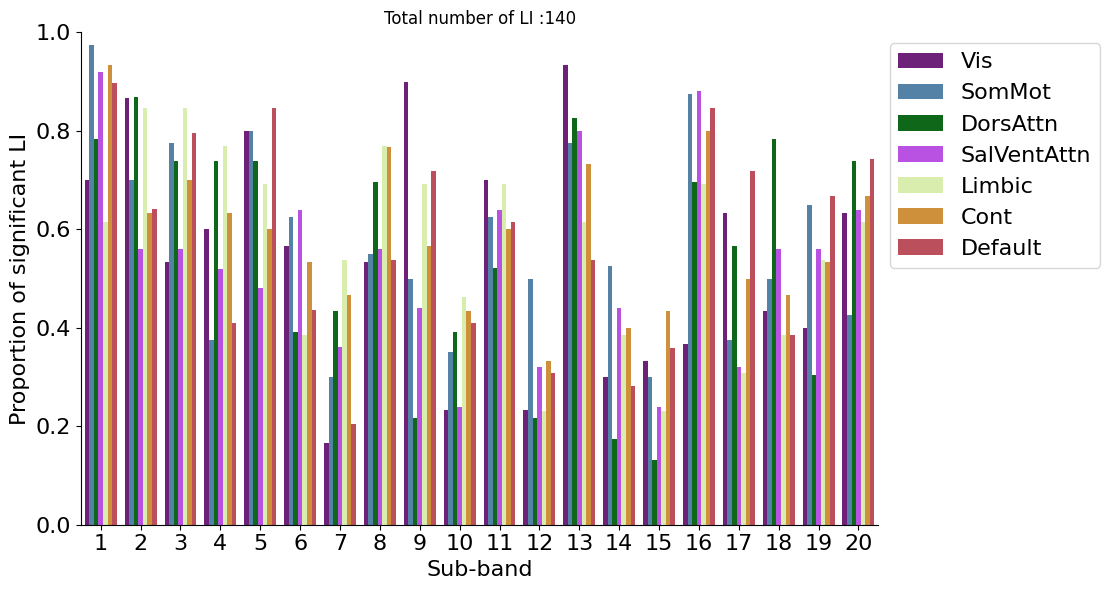

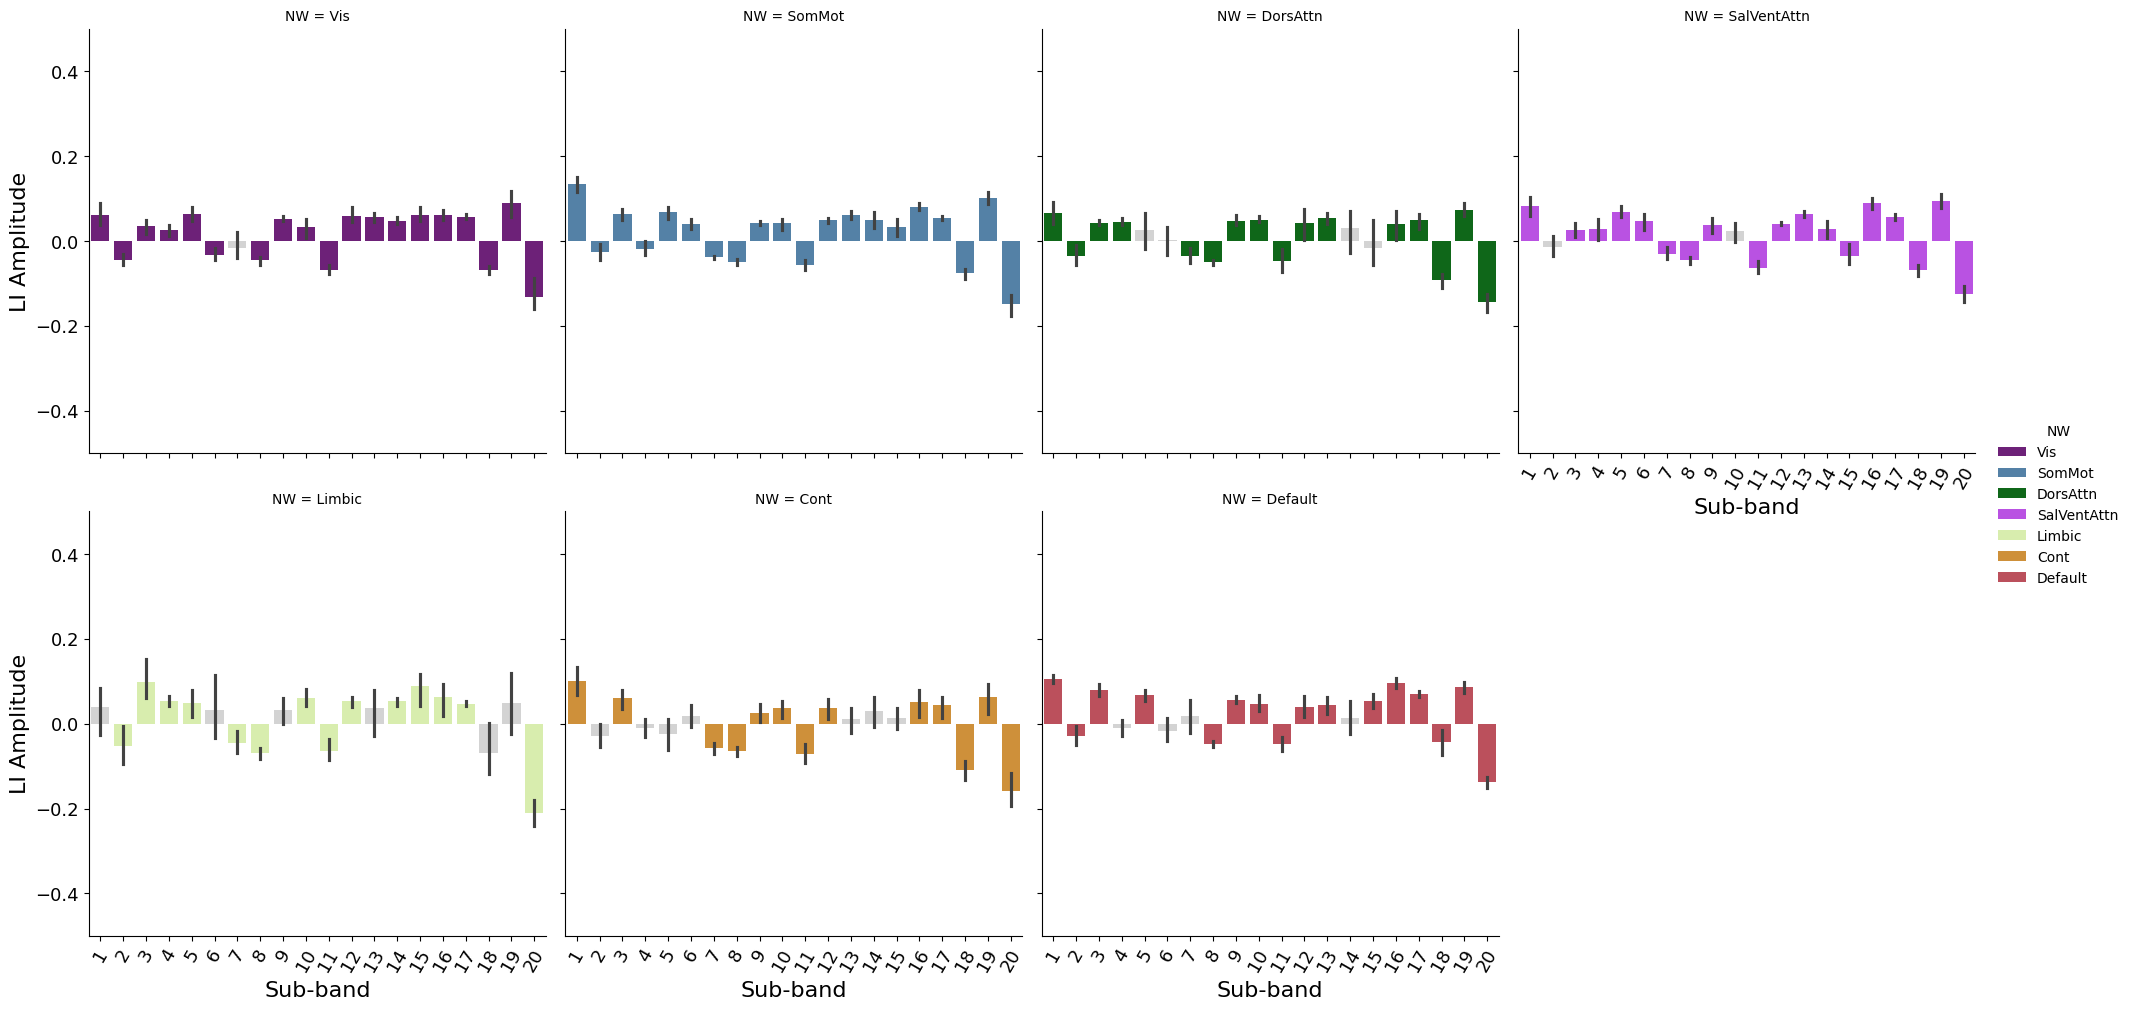

In [95]:
# 1st Subject
subject = 751348
sub_df = final[final.Subject==subject]
# LI Proportion - Subject 1
## Get the proportion : total_number LI / max signficant LI
df_count_sub_un=sub_df.groupby(['NW', 'Significant_LI', 'Subject']).size().reset_index(name='counts')
df_count_sub_un['Proportion'] = df_count_sub_un.apply(lambda row: row['counts'] / dictionnary_HCP[row['NW']], axis=1)

get_dist(df_count_sub_un, "plot/Subject/dist_subject_first.png", color_dict_HCP, 'NW', hue_order_HCP)

# LI Spectrum - Subject 1
plot_with_custom_colors_LI(sub_df, y="LI_Amplitude", x='Significant_LI', hue='NW', col='NW', col_wrap=4,
                        hue_order=hue_order_HCP, color_dict=color_dict_HCP, 
                        save_file=f"plot/Subject/one_subject_first.png", ylim=[-0.5, 0.5])

- 2nd subject

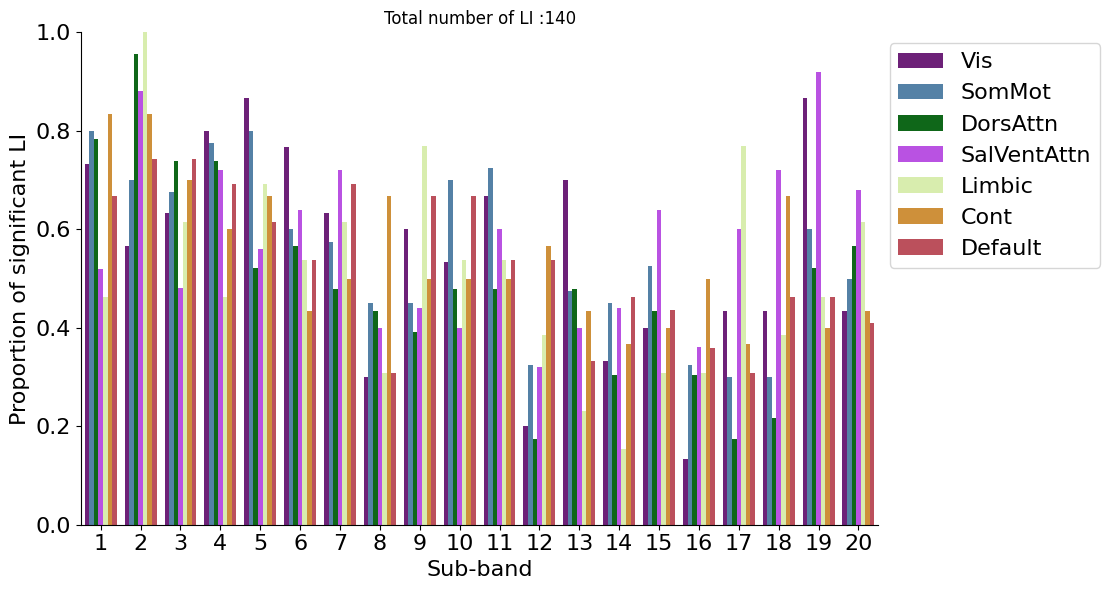

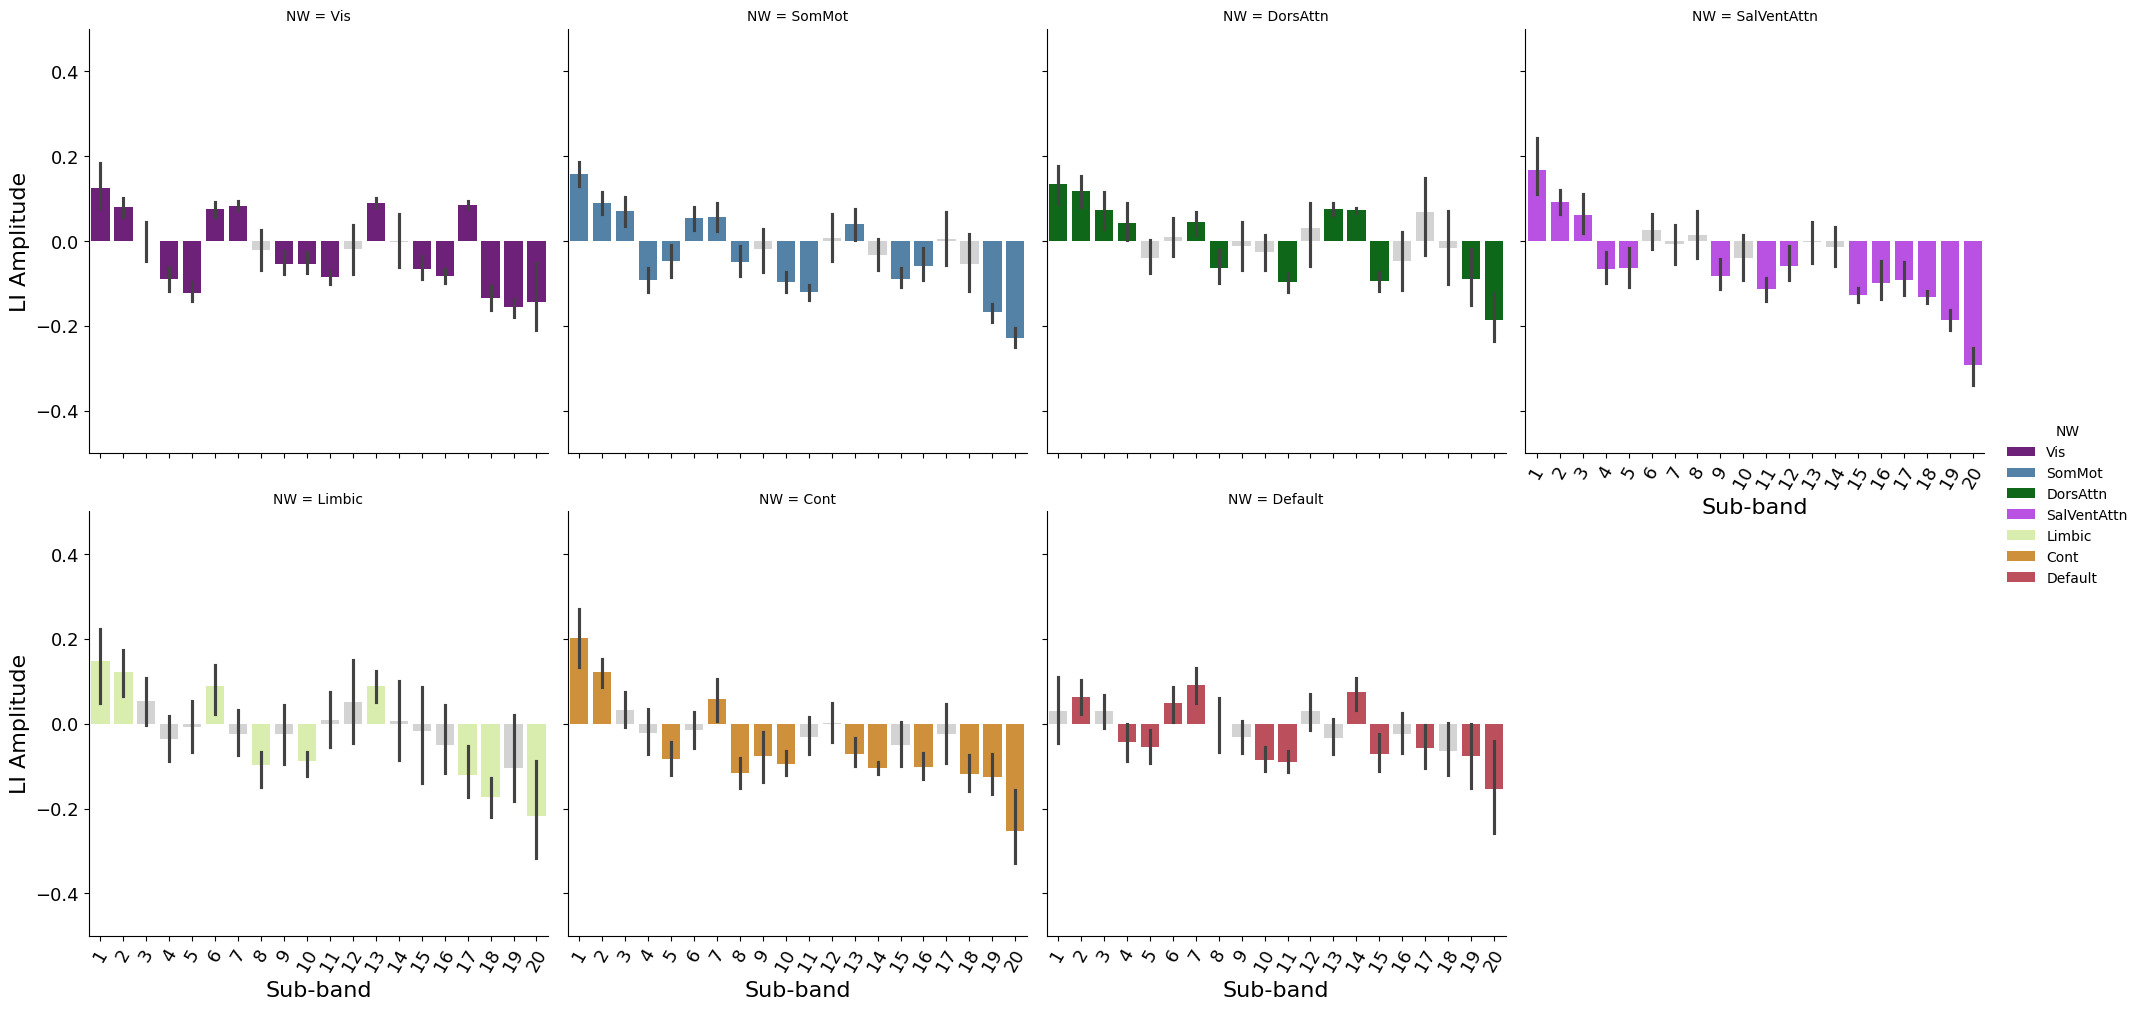

In [96]:
# 2nd Subject 
subject = 212318
sub_df = final[final.Subject==subject]

# LI Proportion - Subject 2
df_count_sub_two=sub_df.groupby(['NW', 'Significant_LI', 'Subject']).size().reset_index(name='counts')
df_count_sub_two['Proportion'] = df_count_sub_two.apply(lambda row: row['counts'] / dictionnary_HCP[row['NW']], axis=1)
get_dist(df_count_sub_two, "plot/Subject/dist_subject_second.png", color_dict_HCP, 'NW', hue_order_HCP)

# LI spectrum - subject 2
plot_with_custom_colors_LI(sub_df, y="LI_Amplitude", x='Significant_LI', hue='NW', col='NW', col_wrap=4,
                        hue_order=hue_order_HCP, color_dict=color_dict_HCP, save_file=f"plot/Subject/one_subject_second.png", ylim=[-0.5, 0.5])


### Population Analysis 

This analysis includes an overall population analysis and a second analysis separating left-handers from right-handers.


- Overall opulation analysis

In [98]:
df_count_all=final.groupby(['NW', 'Significant_LI', 'Subject']).size().reset_index(name='counts')
df_count_all

,NW,Significant_LI,Subject,counts
0,Cont,1,100307,22
1,Cont,1,100408,21
2,Cont,1,101107,22
3,Cont,1,101309,24
4,Cont,1,101915,22
...,...,...,...,...
13683,Vis,20,756055,7
13684,Vis,20,792564,25
13685,Vis,20,856766,9
13686,Vis,20,857263,10


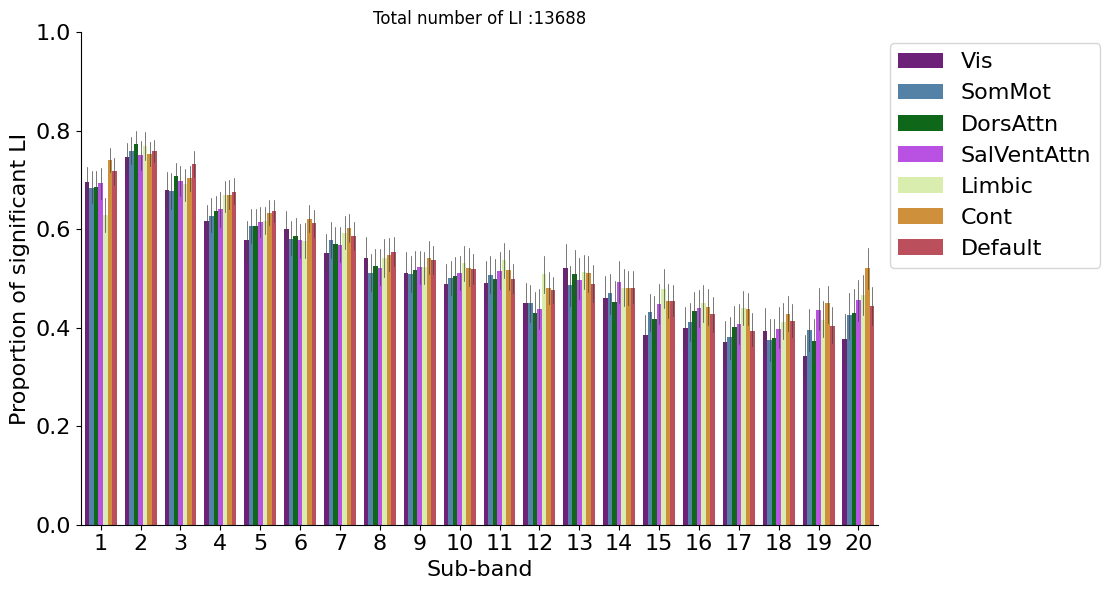

F-statistic: 24.336293429535935
P-value: 0.0004528535020445157
P-value: 0.0004528535020445157
There is a significant difference in the means of the numerical variable between the groups for the suband 1.
F-statistic: 14.308143407331547
P-value: 0.02637718198262322
P-value: 0.02637718198262322
There is a significant difference in the means of the numerical variable between the groups for the suband 12.
F-statistic: 17.40123725907165
P-value: 0.007916423199502615
P-value: 0.007916423199502615
There is a significant difference in the means of the numerical variable between the groups for the suband 15.
F-statistic: 14.472121788000512
P-value: 0.024784689739973373
P-value: 0.024784689739973373
There is a significant difference in the means of the numerical variable between the groups for the suband 17.
F-statistic: 19.91187215930232
P-value: 0.002871203889968608
P-value: 0.002871203889968608
There is a significant difference in the means of the numerical variable between the groups for the

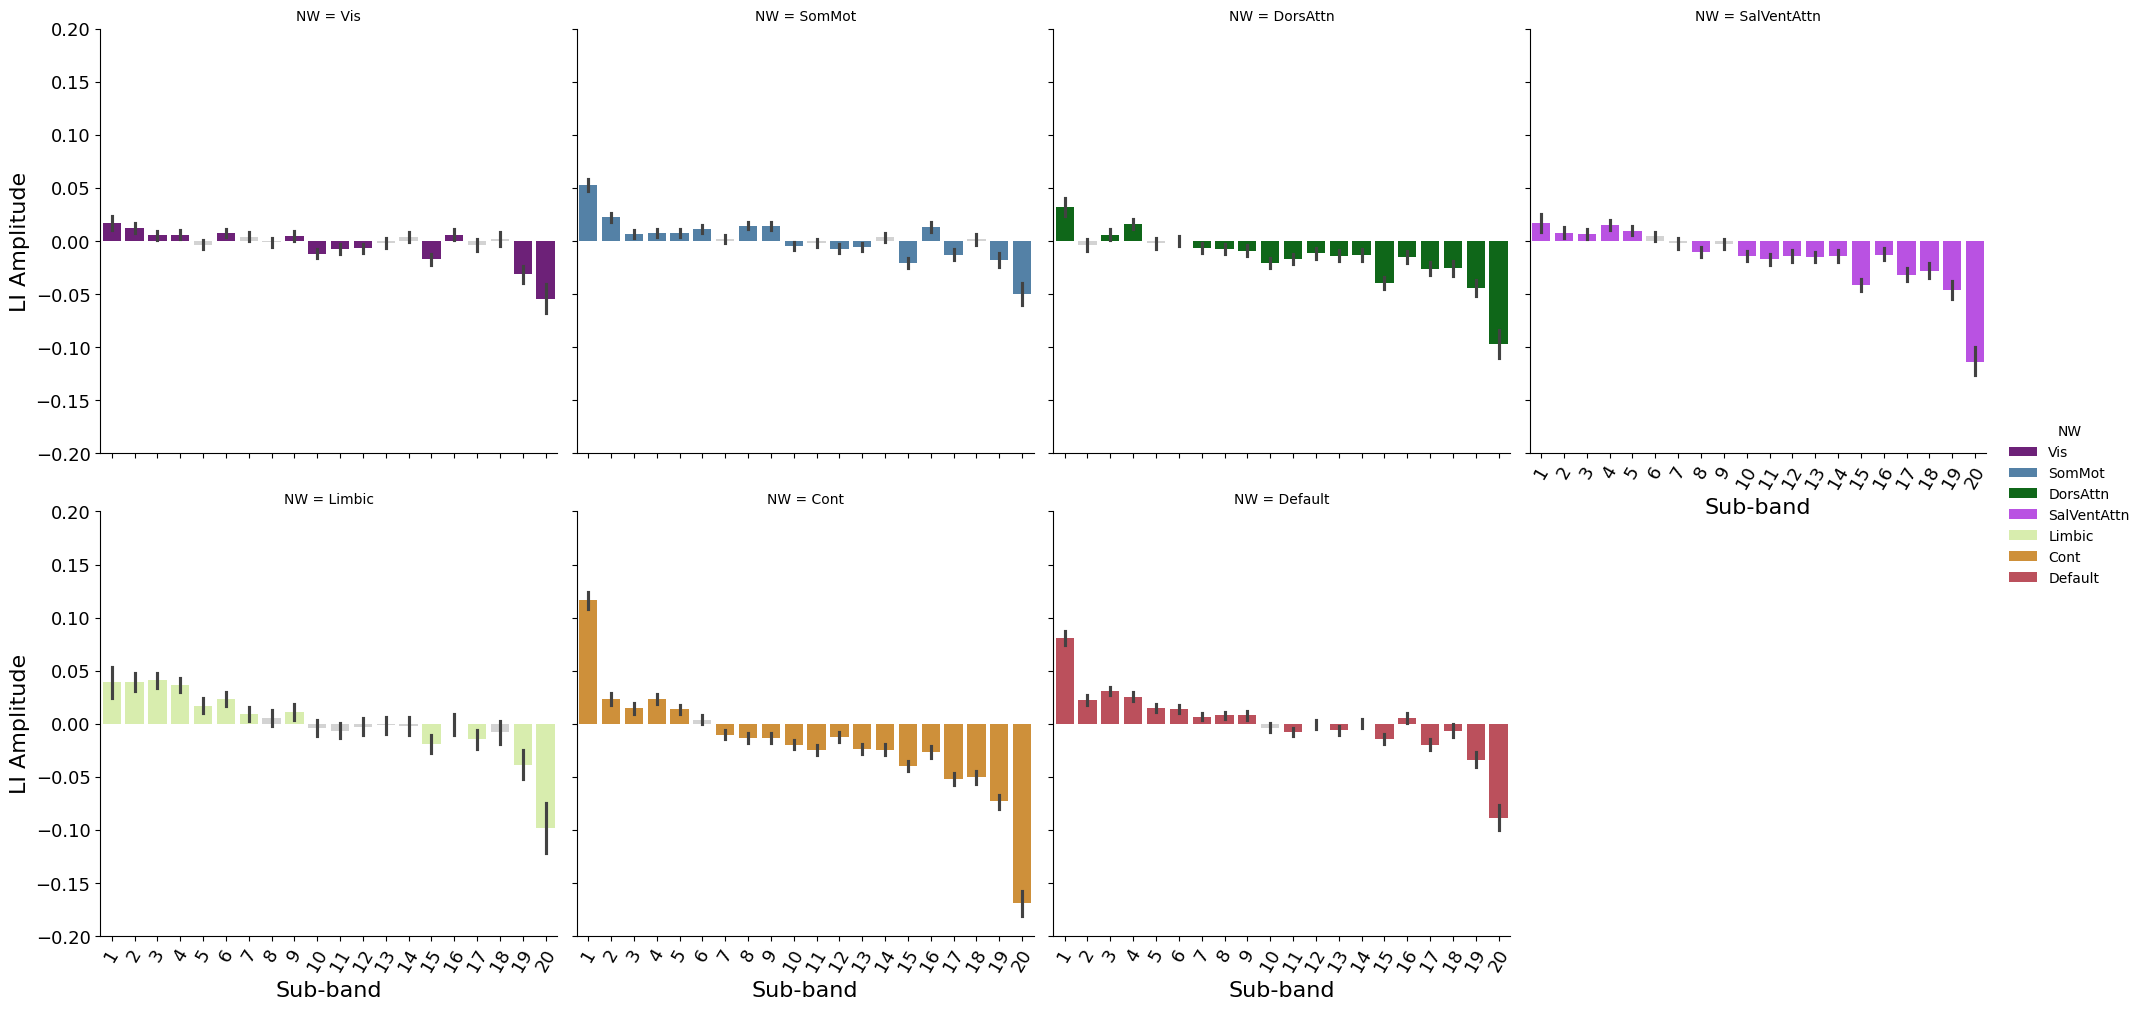

In [103]:
# LI poportionn
df_count_all=final.groupby(['NW', 'Significant_LI', 'Subject']).size().reset_index(name='counts')
df_count_all['Proportion'] = df_count_all.apply(lambda row: row['counts'] / dictionnary_HCP[row['NW']], axis=1)
get_dist(df_count_all,"plot/all/SSBCAPS_RH.png" , color_dict_HCP, 'NW', hue_order_HCP)
# Stat testing to measure network LI proportion differences within each sub-band
get_signficance(df_count_all, 20, 'NW')
# LI spectrum 
plot_with_custom_colors_LI(final, y="LI_Amplitude", x='Significant_LI', hue='NW', col='NW', col_wrap=4,
                        hue_order=hue_order_HCP, color_dict=color_dict_HCP, save_file=f"plot/all/SSBCAP_RH_amplitude.png", ylim=[-0.2, 0.2])

In [102]:
# Report overall lateralization
mean_nw=final.groupby(['NW'])['LI_Amplitude'].mean()
for network in final.NW.unique(): 
    if(mean_nw[network]>0) : 
        print(f"Overall rigthward tendancy for network {network}")
    if(mean_nw[network]<0) : 
        print(f"Overall leftward tendancy for network {network}")
    if(mean_nw[network]==0) : 
        print(f"No overall asym tendancy for network {network}")

Overall leftward tendancy for network Vis
Overall rigthward tendancy for network SomMot
Overall leftward tendancy for network DorsAttn
Overall leftward tendancy for network SalVentAttn
Overall rigthward tendancy for network Limbic
Overall leftward tendancy for network Cont
Overall rigthward tendancy for network Default


In [114]:
# Get the region importance -Plotting in matlab
normalized_counts=(final.groupby(['Map_Name'])['Significant_LI'].size()/(20*98)).reset_index()
normalized_counts
desired_order = [f'SSBCAP_{i}' for i in range(1, 401)]
normalized_counts['Map_Name'] = pd.Categorical(normalized_counts['Map_Name'], categories=desired_order, ordered=True)
sorted_df = normalized_counts.sort_values('Map_Name').reset_index(drop=True)
from scipy.io import savemat
savemat( "data/Proportion_asym_per_region.mat", {'imp':sorted_df.Significant_LI.values})

- Left and Right hander analysis

In [109]:
# Grouping
left_handler = final[final.Handedness=='left']
right_handler = final[final.Handedness=='right']
n_sample=len(left_handler.Subject.unique())
selected_subjects = right_handler['Subject'].unique()
selected_subjects_sample = pd.Series(selected_subjects).sample(n=n_sample, random_state=42).values
df_selected_right= right_handler[right_handler['Subject'].isin(selected_subjects_sample)]

13


- Left hander

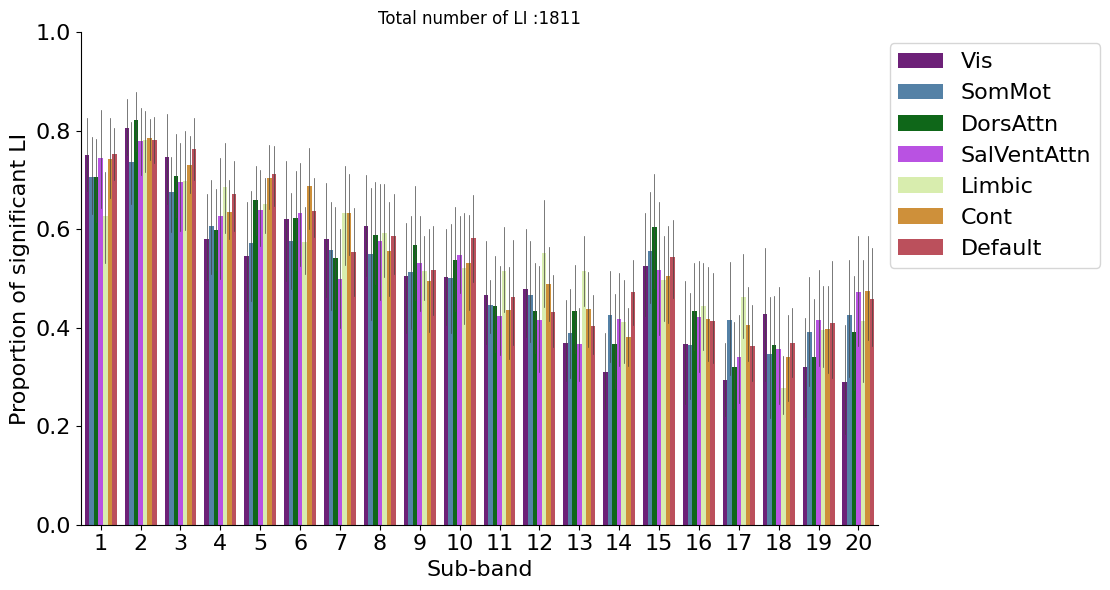

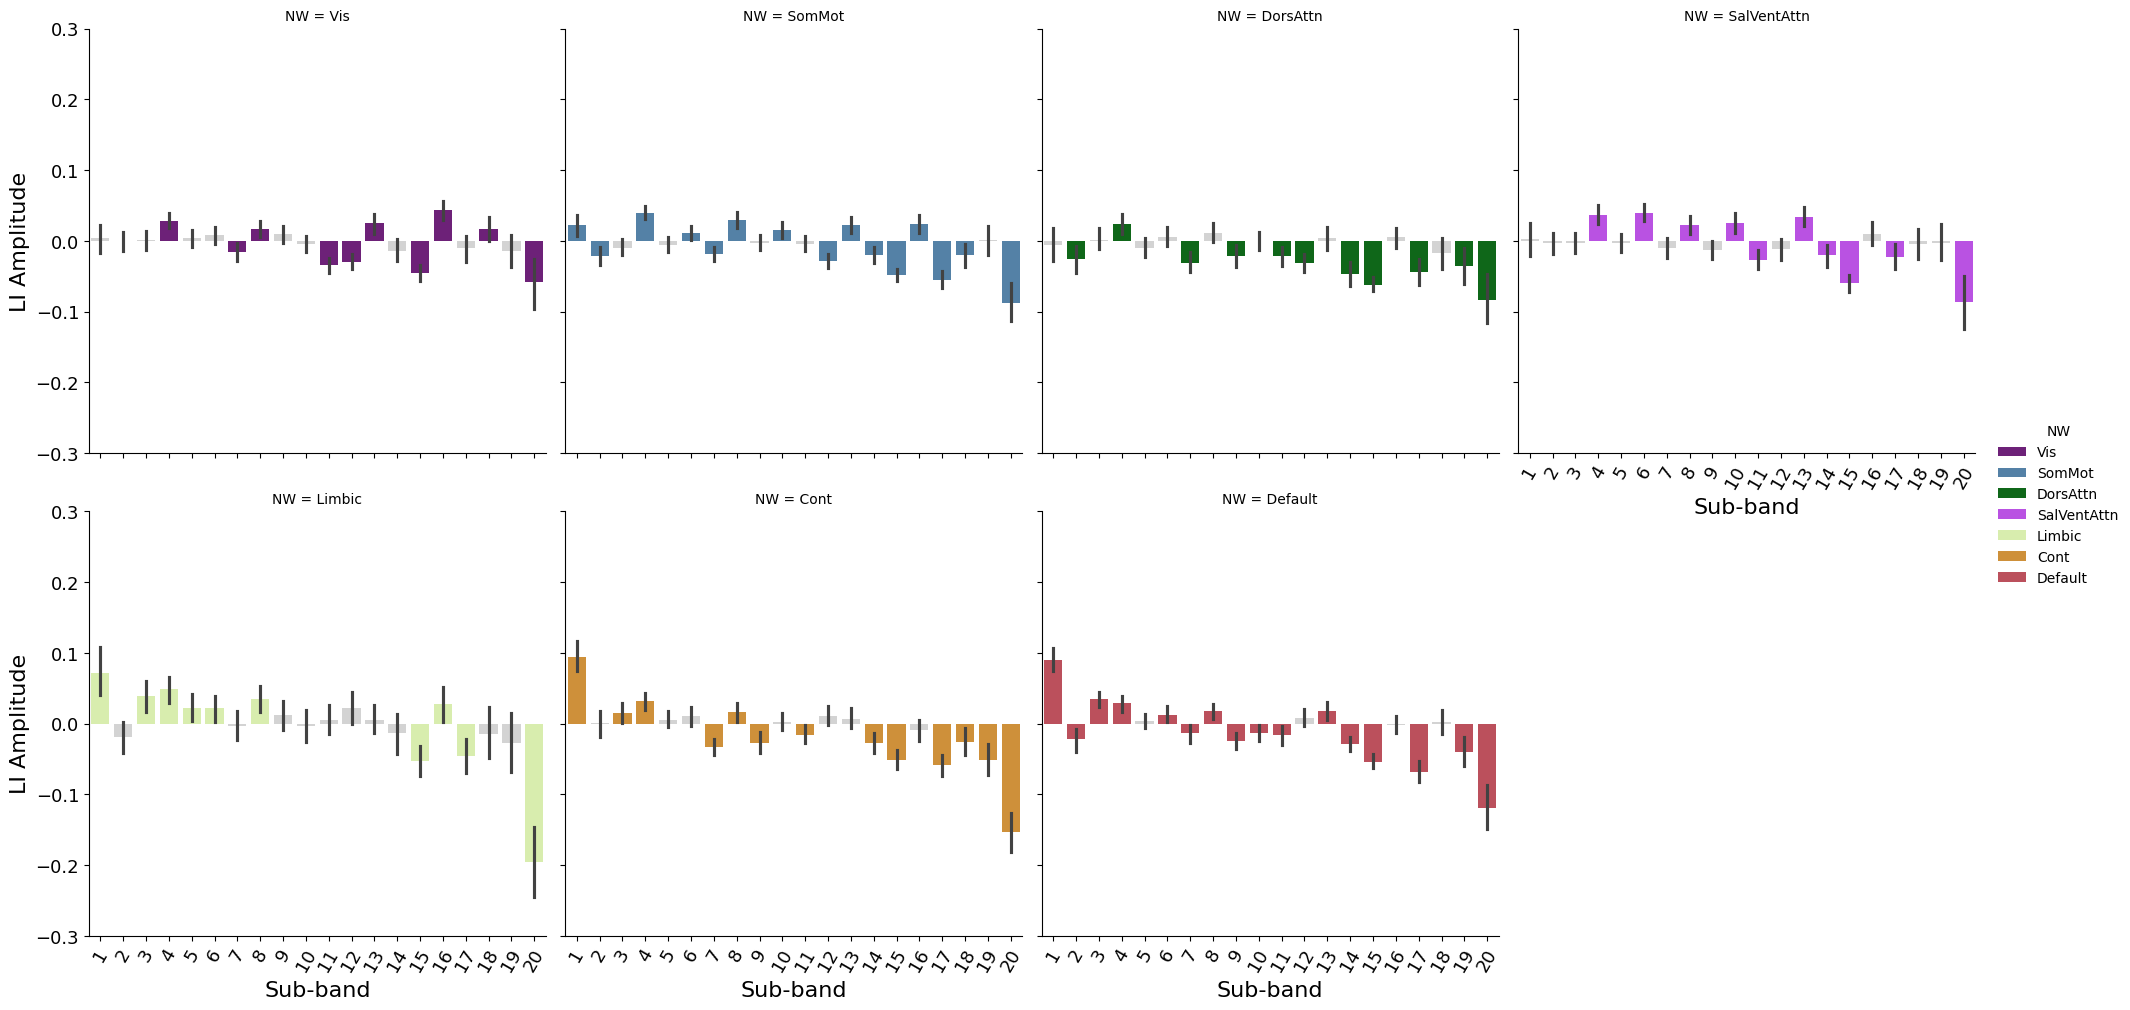

In [111]:

df_count_hand_left=left_handler.groupby(['NW', 'Significant_LI', 'Subject']).size().reset_index(name='counts')
df_count_hand_left['Proportion'] = df_count_hand.apply(lambda row: row['counts'] / dictionnary_HCP[row['NW']], axis=1)
get_dist(df_count_hand_left,"plot/all/SSBCAPS_LH.png" , color_dict_HCP, 'NW', hue_order_HCP)

plot_with_custom_colors_LI(left_handler, y="LI_Amplitude", x='Significant_LI', hue='NW', col='NW', col_wrap=4,
                        hue_order=hue_order_HCP, color_dict=color_dict_HCP, save_file=f"plot/all/plt_amplitude_left.png", ylim=[-0.3, 0.3])

- Right hander

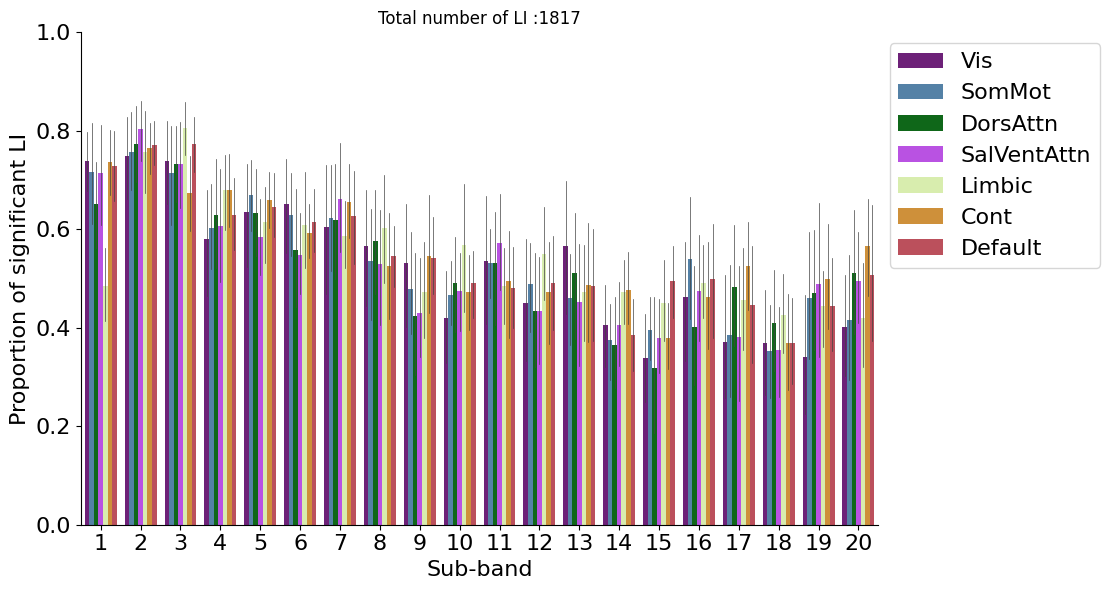

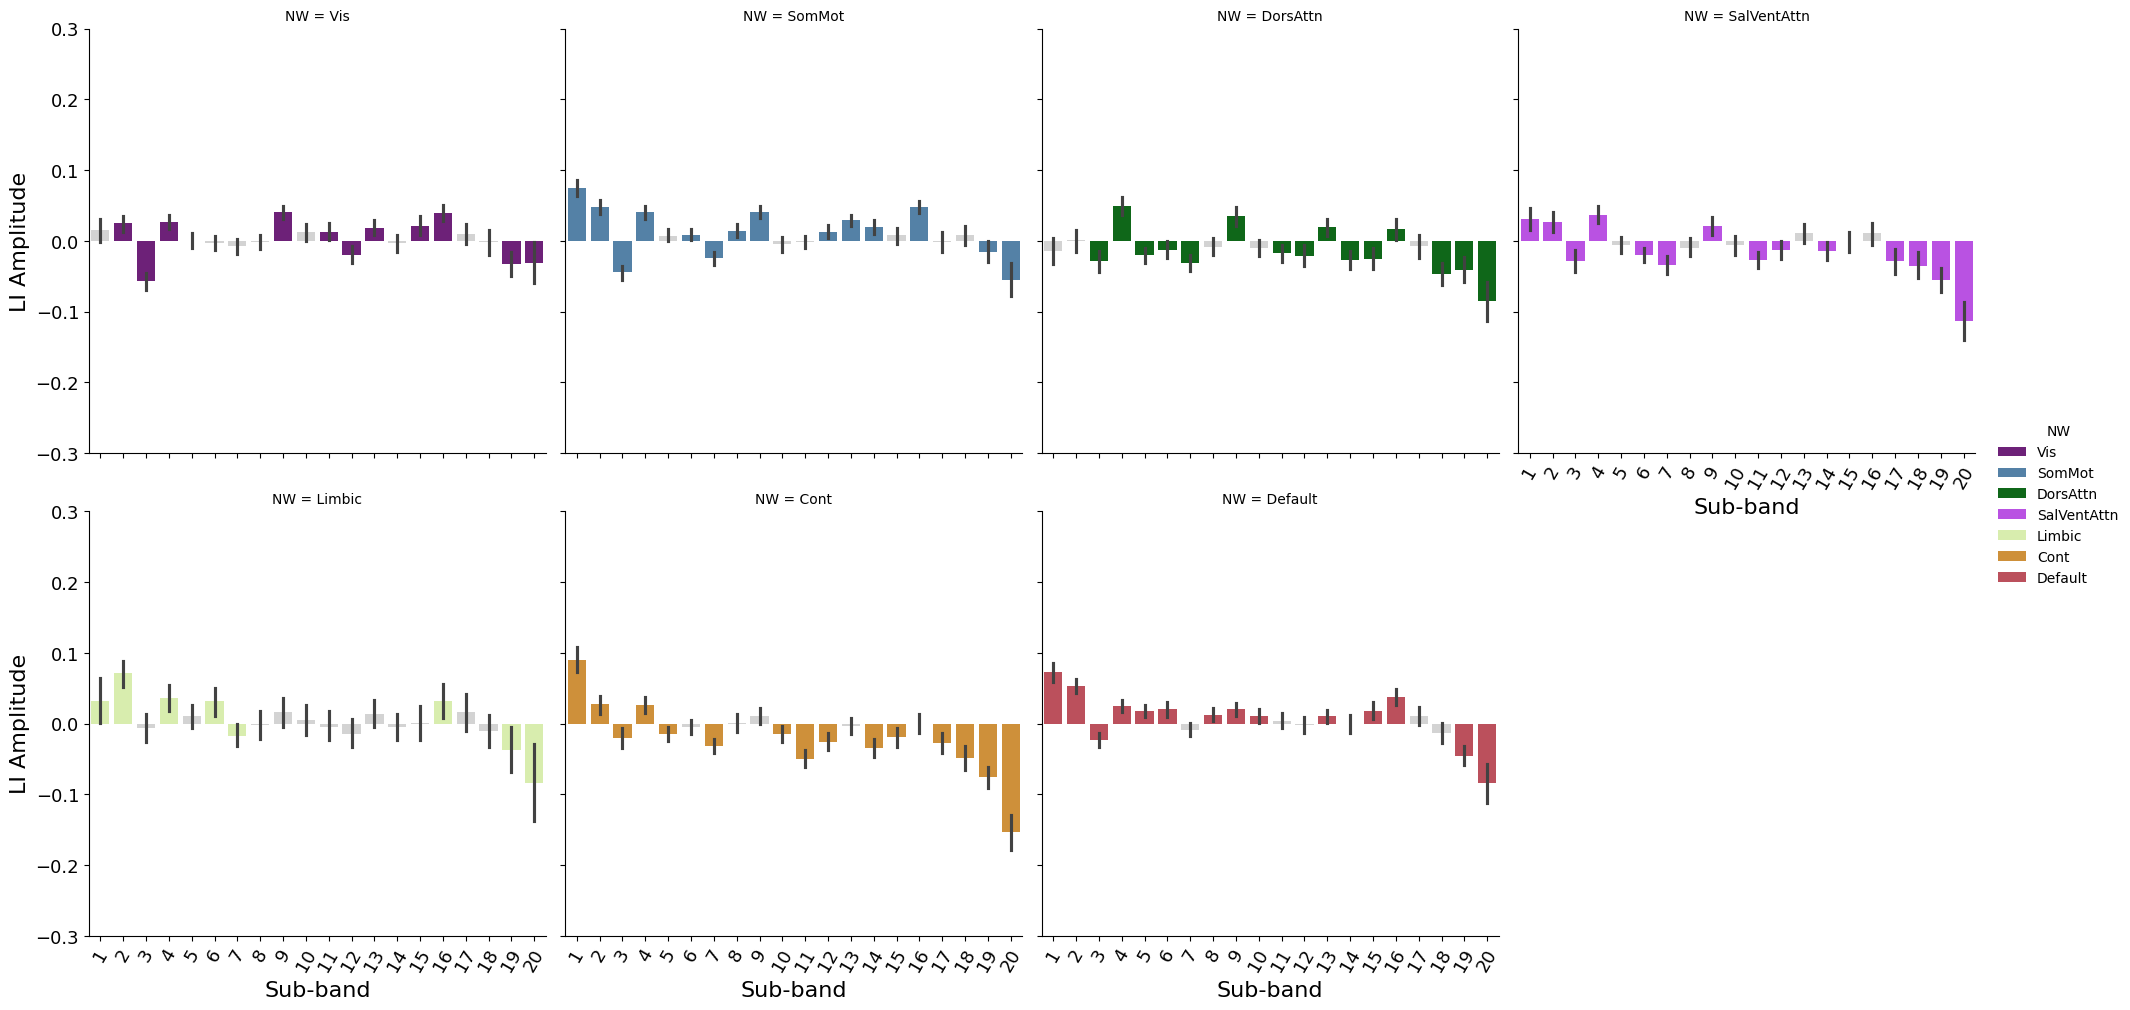

In [112]:
df_count_right=df_selected_right.groupby(['NW', 'Significant_LI', 'Subject']).size().reset_index(name='counts')
df_count_right['Proportion'] = df_count_right.apply(lambda row: row['counts'] / dictionnary_HCP[row['NW']], axis=1)
get_dist(df_count_right,"plot/all/SSBCAPS_RH.png" , color_dict_HCP, 'NW', hue_order_HCP)
plot_with_custom_colors_LI(df_selected_right, y="LI_Amplitude", x='Significant_LI', hue='NW', col='NW', col_wrap=4,
                        hue_order=hue_order_HCP, color_dict=color_dict_HCP, save_file=f"plot/all/plt_amplitude_right.png", ylim=[-0.3, 0.3])

In [113]:
# stat diff bewteen the netowrk 

final_hand=pd.concat([df_selected_right, left_handler])
for  nw  in final_hand.NW.unique(): 
    sub_df=final_hand[final_hand.NW==nw]
    #std_group=sub_df.groupby(['Handedness'])['LI_Amplitude'].std()
    grouped_df = sub_df.groupby(['Handedness'])['LI_Amplitude'].apply(list)
    f_statistic, p_value = stats.kruskal(*grouped_df)
    # Interpret the result
    if p_value < 0.05:
        print(f"F-statistic: {f_statistic}")
        print(f"P-value: {p_value}")
        print(f"There is a significant difference in the means of the numerical variable between the netowrk for the suband {nw}.")


F-statistic: 4.407399067495707
P-value: 0.03578336001582321
There is a significant difference in the means of the numerical variable between the netowrk for the suband Vis.
F-statistic: 85.42096329863723
P-value: 2.4115041668483566e-20
There is a significant difference in the means of the numerical variable between the netowrk for the suband SomMot.
F-statistic: 7.106803448779886
P-value: 0.00767919253920963
There is a significant difference in the means of the numerical variable between the netowrk for the suband SalVentAttn.
F-statistic: 6.8390511723779435
P-value: 0.00891861978309368
There is a significant difference in the means of the numerical variable between the netowrk for the suband Cont.
F-statistic: 42.23397608828163
P-value: 8.09808215108617e-11
There is a significant difference in the means of the numerical variable between the netowrk for the suband Default.


/var/folders/y2/0_3696zj1n31nzsd19ftjwq40000gp/T/ipykernel_96673/1469726474.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = sub_df.groupby(['Handedness'])['LI_Amplitude'].apply(list)


# BioFINDER-2 Dataset

In [119]:
#Data Loading
AD = pd.read_pickle("data/AD_BF_500_01.pkl")
MCI = pd.read_pickle("data/MCI_BF_500_01.pkl")
group1 = pd.read_pickle("data/group_un_BF_500_01.pkl")
group2 = pd.read_pickle("data/group_deux_BF_500_01.pkl")
dic_norma={'AD':172, 'MCI':93, 'group1':88,'group2':94}
hue_order=['group1', 'group2', 'MCI', 'AD']
color_dict={'AD': (0.86, 0.3712, 0.33999999999999997),
             'MCI': (0.5688000000000001, 0.86, 0.33999999999999997), 
             'group1': (0.33999999999999997, 0.8287999999999999, 0.86), 
             'group2': (0.6311999999999998, 0.33999999999999997, 0.86)}

- Example for one subject

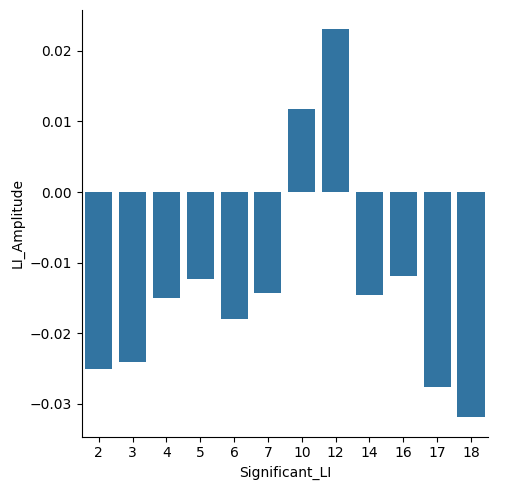

In [116]:
#One subject Example LI spectrum
sns.catplot(group1[group1.Subject==244], x='Significant_LI', y='LI_Amplitude', kind='bar')

- group level analysis

In [117]:
# Informations
print(f"Number of subject AD {len(AD.Subject.unique())} / expected number : {dic_norma['AD']}")
print(f"Number of subject MCI {len(MCI.Subject.unique())} / expected number : {dic_norma['MCI']}")
print(f"Number of subject Group one {len(group1.Subject.unique())} / expected number : {dic_norma['group1']}")
print(f"Number of subject group two {len(group2.Subject.unique())} / expected number : {dic_norma['group2']}")

Number of subject AD 172 / expected number : 172
Number of subject MCI 93 / expected number : 93
Number of subject Group one 88 / expected number : 88
Number of subject group two 94 / expected number : 94


In [118]:
# Add identifiers to each DataFrame
AD['Disease'] = 'AD'
MCI['Disease'] = 'MCI'
group1['Disease'] = 'group1'
group2['Disease'] = 'group2'
info=pd.read_csv("data/BF2_1365.txt", sep="\t")
info.rename(columns={"ID": "Subject"}, inplace=True)
combined_df = pd.concat([AD, MCI, group1, group2])
clinical_df = combined_df.merge(info, on='Subject')

,Subject,LI_Amplitude,Significant_LI,Disease,dx,age,gender,tauPET,abnormalAmyloidCSF
0,118,-0.024365,1,AD,AD,63,man,2.92,1.0
1,118,-0.02814,2,AD,AD,63,man,2.92,1.0
2,118,0.037842,3,AD,AD,63,man,2.92,1.0
3,118,-0.058096,4,AD,AD,63,man,2.92,1.0
4,118,-0.011119,5,AD,AD,63,man,2.92,1.0
...,...,...,...,...,...,...,...,...,...
6434,2038,-0.010174,11,group2,Normal,80,woman,1.19,1.0
6435,2038,-0.00771,12,group2,Normal,80,woman,1.19,1.0
6436,2038,0.013727,13,group2,Normal,80,woman,1.19,1.0
6437,2038,0.027232,17,group2,Normal,80,woman,1.19,1.0


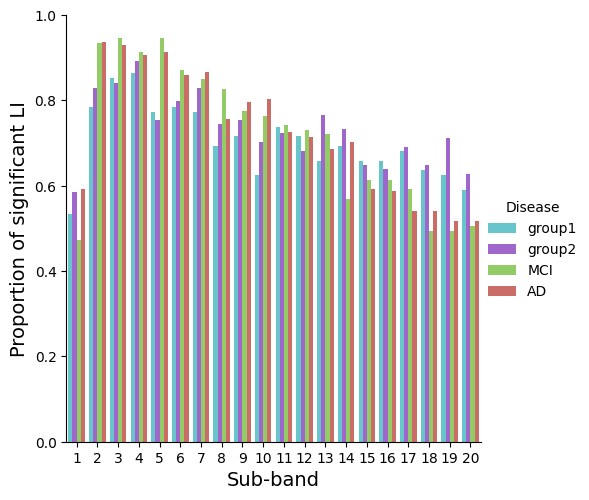

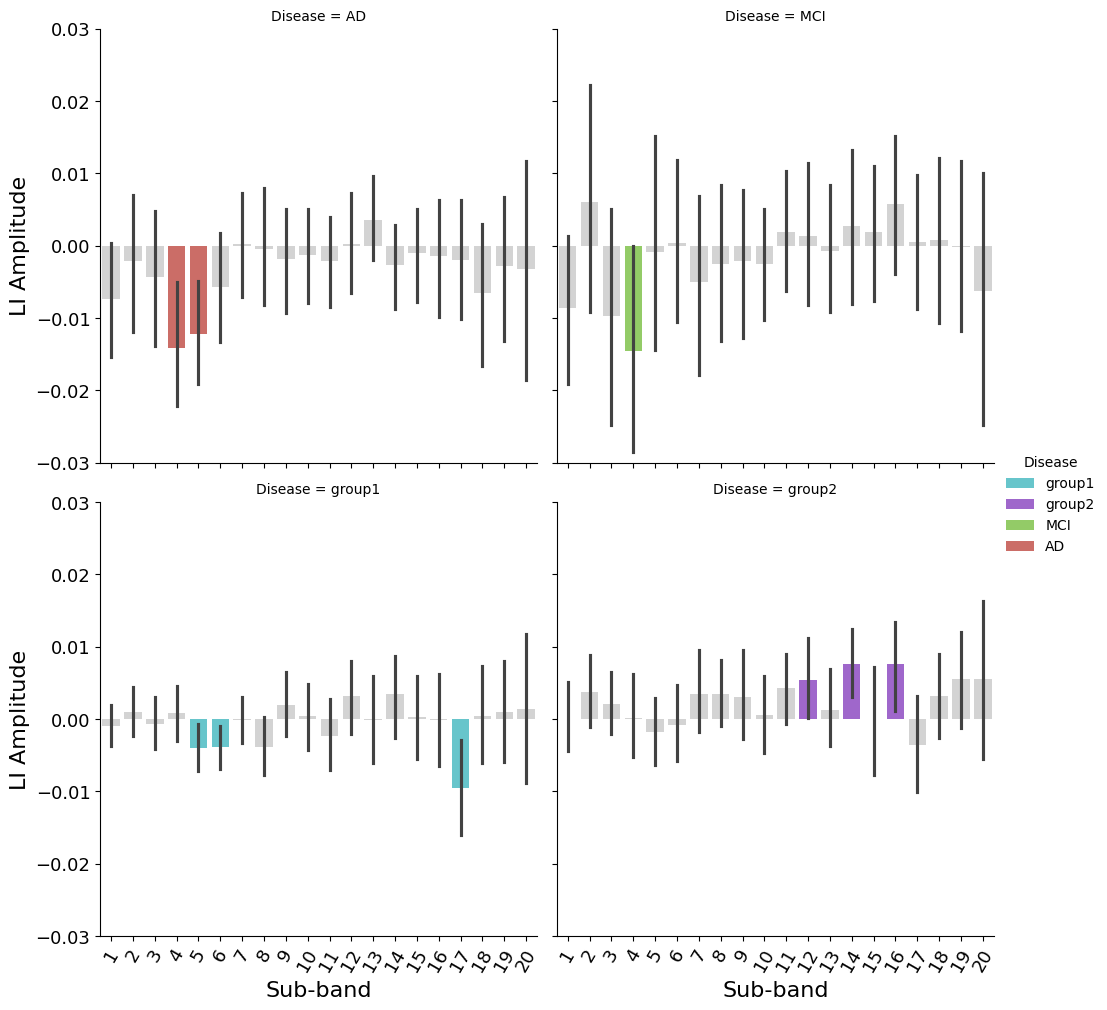

In [123]:
# Proportion of LI 
df_count_clinic=clinical_df.groupby(['Disease', 'Significant_LI']).size().reset_index(name='counts')
df_count_clinic['Proportion'] = df_count_clinic.apply(lambda row: row['counts'] / dic_norma[row['Disease']], axis=1)
sns.catplot(df_count_clinic, y="Proportion", 
        x='Significant_LI', 
        hue='Disease', 
        palette=color_dict,
        hue_order=hue_order,
        kind='bar')
plt.ylim(0,1)
plt.ylabel("Proportion of significant LI", fontsize=14)
plt.xlabel("Sub-band", fontsize=14)
plt.savefig("plot/all/clinical.png")
#Spectrum LI
plot_with_custom_colors_LI(clinical_df, y="LI_Amplitude", x='Significant_LI', hue='Disease', col='Disease', col_wrap=2, hue_order=['group1', 'group2', 'MCI', 'AD'],
                        color_dict=color_dict, save_file=f"plot/all/plt_test_disease.png.", ylim=[-0.03, 0.03])


- Explore 4th sub-band and it association with Tau

before removal


/var/folders/y2/0_3696zj1n31nzsd19ftjwq40000gp/T/ipykernel_96673/1589716287.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Disease', y='LI_Amplitude', data=sub_df_clean, palette=color_dict)


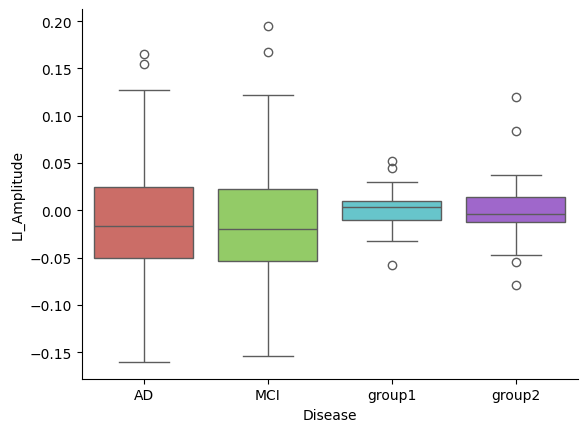

after removal


/var/folders/y2/0_3696zj1n31nzsd19ftjwq40000gp/T/ipykernel_96673/1589716287.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Disease', y='tauPET', data=sub_df_clean, palette=color_dict)


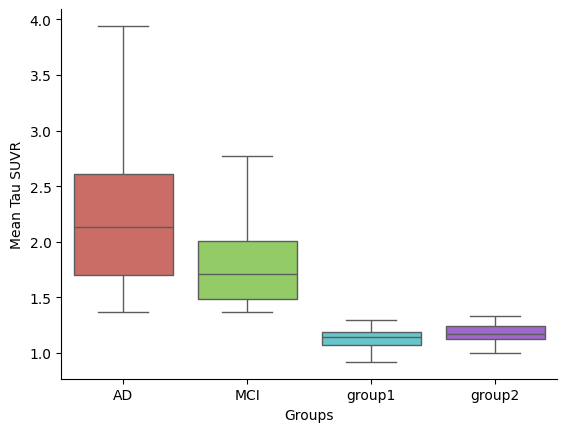

/Users/al2517mi/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/al2517mi/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/al2517mi/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/al2517mi/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     7.650
Date:                Sun, 18 Aug 2024   Prob (F-statistic):            0.00606
Time:                        15:05:52   Log-Likelihood:                -250.22
No. Observations:                 277   AIC:                             504.4
Df Residuals:                     275   BIC:                             511.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6780      0.036     46.599      0.0

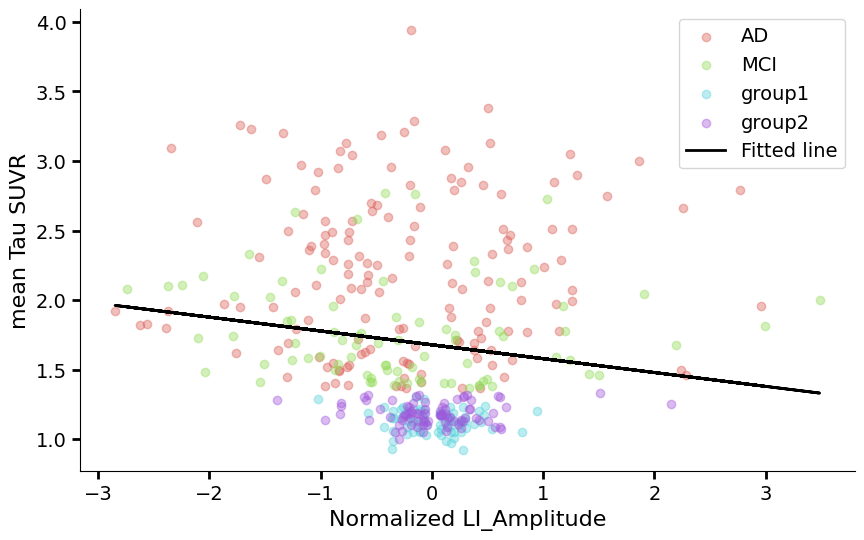

In [125]:
sub_df=clinical_df[clinical_df.Significant_LI==4]

# Apply outlier removal to each group and combine the results
ad_clean = remove_outliers_groupwise(sub_df, 'tauPET', 'Disease', 'AD')
mci_clean = remove_outliers_groupwise(sub_df, 'tauPET', 'Disease', 'MCI')
group1_clean = remove_outliers_groupwise(sub_df, 'tauPET', 'Disease', 'group1')
group2_clean = remove_outliers_groupwise(sub_df, 'tauPET', 'Disease', 'group2')

# Combine the cleaned groups back into one DataFrame
sub_df_clean = pd.concat([ad_clean, mci_clean, group1_clean, group2_clean])

# Boxplot for Tau SUVR 
sns.boxplot(x='Disease', y='LI_Amplitude', data=sub_df_clean, palette=color_dict)
print('before removal')
sns.despine()
plt.savefig("Boxplot_before_removal.png")
plt.show()
sns.boxplot(x='Disease', y='tauPET', data=sub_df_clean, palette=color_dict)
plt.xlabel('Groups')
plt.ylabel('Mean Tau SUVR')
print('after removal')
sns.despine()
plt.savefig("Boxplot_after_removal.png")
plt.show()

# Deifnition dataset
X = sub_df_clean[['LI_Amplitude']].values  
y = sub_df_clean['tauPET'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standarized the X
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

# Add a constant to the predictor variable matrix for both train and test sets
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the regression model on the training set and predict
model = sm.OLS(y_train, X_train).fit())
y_pred = model.predict(X_test)
print(model.summary()

#  Accuracy measure
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
for disease, color in color_dict.items():
    disease_data = sub_df_clean[sub_df_clean['Disease'] == disease]
    X_disease = scaler.transform(disease_data[['LI_Amplitude']])
    plt.scatter(X_disease, disease_data['tauPET'], color=color, label=disease, alpha=0.4)
plt.plot(X_test[:, 1], y_pred, color='black', linewidth=2, label='Fitted line')
plt.xlabel('Normalized LI_Amplitude', fontsize=16)
plt.ylabel('mean Tau SUVR', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)
plt.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1)
sns.despine()
plt.savefig("plot/linear_ref.png")
plt.show()